In [1]:
!pip install folium
!pip install geopandas
!pip install contextily
!pip install colormaps

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import folium
import random 

import geopandas as gpd
import contextily as ctx

import networkx as nx
from matplotlib import colormaps

In [3]:
passagers = pd.read_csv("../data_chall_alstom/passagers.csv")
print(passagers.info())
plan_metro = pd.read_csv("../data_chall_alstom/plan_du_métro.csv")
print(plan_metro.info())
position_gps = pd.read_csv("../data_chall_alstom/position_gps_des_stations_de_métro.csv")
print(position_gps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  385 non-null    object
 1   GPS      385 non-null    object
d

### Mis en forme des jeu de données

In [4]:
plan_metro_ligne = plan_metro[plan_metro["de Station"]!=plan_metro["vers Station"]]
position_gps['lat'], position_gps['lng'] = zip(*position_gps['GPS'].apply(lambda x: x.split(',')))

In [5]:
stations=[]
"""
ligne_nb = list(range(1,15))
ligne_nb=[chr(x) for x in ligne_nb]
ligne_nb.append("3bis")
ligne_nb.append("7bis")
"""
ligne_nb=["1","2","3","3bis","4","5","6","7","8","9","10","11","12","13","14","7bis"]

for ligne in ligne_nb :
    liste_coord=[]
    df_lignei=plan_metro_ligne[plan_metro_ligne["de Ligne"]==ligne]
    station = df_lignei["de Station"].unique()

    for st in station:
        if not(position_gps[position_gps['Station']==st].empty):
            liste_coord.append([float(position_gps[position_gps['Station']==st].iat[0,3]), float(position_gps[position_gps['Station']==st].iat[0,2])])

        
    
    if ligne!="8":
        pop=liste_coord.pop()
        if ligne=="1" :
            liste_coord.insert(0,pop)
    stations.append({'coordinates' : liste_coord, 'type': 'LineString'})

plan_ligne = pd.DataFrame()
plan_ligne["ligne"] = ligne_nb
plan_ligne["station"] = stations

### Representation graphique du reseau

In [6]:
ligne_1=plan_ligne.loc[7]
idf_map = folium.Map(location=[48.868, 2.365], zoom_start=12, tiles='Cartodb dark_matter')


for segment in plan_ligne["station"]:
    gjson = folium.features.GeoJson(segment,
                                    style_function = lambda x: {'color': '#ED6852',
                                                                'weight': 1.5})
    idf_map.add_child(gjson)


for i, v in position_gps.iterrows():
    folium.CircleMarker(location=[v['lat'], v['lng']],
                        radius=1.2,
                        color='#FFFFF0',
                        fill_color='#FFFFFF',
                        fill=True).add_to(idf_map)
idf_map

### Creation de la matrice

In [7]:
import math

#On calcule la distance avec la formule de Haversine
def calcul_distance(station1, station2):
    coord_station1 = position_gps.loc[position_gps["Station"] == station1, "GPS"].iloc[0]
    coord_station2 = position_gps.loc[position_gps["Station"] == station2, "GPS"].iloc[0]
    lat1 , lon1 = map(float, coord_station1.split(", "))
    lat2 , lon2 = map(float, coord_station2.split(", "))
    # Rayon de la Terre en kilomètres
    R = 6371.0
    
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Différences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Distance
    distance = R * c
    return distance

def calcul_temps(station1,station2,vitesse):
    return round(calcul_distance(station1,station2)/vitesse*3600)

In [9]:
def creation_matrice(plan_metro, position):
    plan_metro_grouped = plan_metro.groupby("de Station")
    passagers_dict = passagers.set_index(["de", "vers"])["nombre"].to_dict()

    # Liste unique des stations
    liste_station = position["Station"].unique()

    # Initialisation d'un dictionnaire pour construire le graph
    graph_dict = {station: [] for station in liste_station}

    # Construction optimisée du graph
    for depuis in liste_station:
        lien = plan_metro_grouped.get_group(depuis)["vers Station"].unique() if depuis in plan_metro_grouped.groups else []

        # Créer une liste pour chaque station de départ
        for vers in liste_station:
            noeud = {
                "ligne": [],
                "passager": passagers_dict.get((depuis, vers), 0) if depuis != vers else 0
            }

            if vers in lien:
                noeud["ligne"] = list(plan_metro[
                    (plan_metro["de Station"] == depuis) & 
                    (plan_metro["vers Station"] == vers)
                ]["de Ligne"].unique())

            graph_dict[depuis].append(noeud)

    # Conversion en DataFrame
    graph = pd.DataFrame(graph_dict, index=liste_station)
    return graph


In [10]:
df=creation_matrice(plan_metro, position_gps)

In [11]:
df

,Boucicaut,Bourse,Bir-Hakeim,Argentine,Daumesnil,Église d'Auteuil,George V,Franklin D. Roosevelt,Europe,Jacques Bonsergent,...,Malakoff - Plateau de Vanves,Tolbiac,Victor Hugo,Poissonnière,Avron,Église de Pantin,Château d'Eau,Guy Môquet,Monceau,Rome
Boucicaut,"{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 2}",...,"{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 5}"
Bourse,"{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 4}",...,"{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 6}"
Bir-Hakeim,"{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 3}",...,"{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 8}"
Argentine,"{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 1}",...,"{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 4}"
Daumesnil,"{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': ['6', '8'], 'passager': 0}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 3}",...,"{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 4}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Église de Pantin,"{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 1}",...,"{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 4}",

In [19]:
def creation_graphe(matrice):
    # Création du graphe avec NetworkX à partir du DataFrame
    G = nx.DiGraph()

    # Ajouter des arêtes au graphe en utilisant les informations du DataFrame
    for start_station in matrice.index:
        for end_station in matrice.columns:
            connection = matrice.loc[start_station, end_station]
            if connection['ligne']!=[] and start_station != end_station:
                G.add_edge(start_station, end_station,
                        lines=connection['ligne'],
                        passagers=connection["passager"])
    # Visualisation (optionnel)
    for i, node in position_gps.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"]))) 
    return G

In [20]:
G_metro = creation_graphe(df)

In [21]:
G_metro.number_of_edges()

530

In [22]:
nx.is_strongly_connected(G_metro)

False

In [23]:
def afficher_graph(G_metro):
    # Récupérer les positions des nœuds pour NetworkX
    pos=nx.get_node_attributes(G_metro, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([position[0] for position in pos.values()], [position[1] for position in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passagers"] for _, _, data in G_metro.edges(data=True)]
    norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
    cmap = colormaps["plasma"]
    edge_colors = [cmap(norm(data["passagers"])) for _, _, data in G_metro.edges(data=True)]

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G_metro,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()

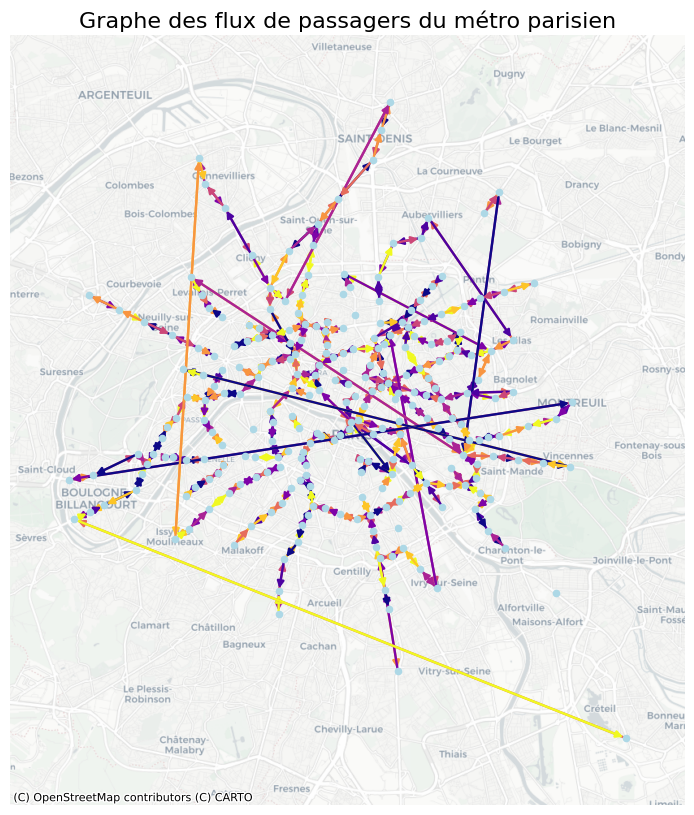

In [24]:
afficher_graph(G_metro)

In [51]:
# Liste des stations à exclure
stations_exclues = [
    "Charles de Gaulle - Étoile", "Champs-Élysées - Clemenceau", "Palais-Royal - Musée du Louvre",
    "Reuilly - Diderot", "Barbès - Rochechouart", "Havre - Caumartin", "Réaumur - Sébastopol",
    "Marcadet - Poissonniers", "Montparnasse - Bienvenüe", "Bobigny - Pablo Picasso",
    "La Motte-Picquet - Grenelle", "Richelieu - Drouot", "Bonne-Nouvelle", "Sèvres - Babylone",
    "Châtillon - Montrouge", "Louvre - Rivoli", "Pereire", "Quatre-Septembre", "Richard-Lenoir",
    "Bréguet - Sabin", "Campo-Formio", "Sèvres - Lecourbe", "Aubervilliers - Pantin - Quatre Chemins",
    "Pont-Neuf", "Sully - Morland", "Censier - Daubenton", "Villejuif - Paul Vaillant-Couturier",
    "Pré-Saint-Gervais", "La Tour-Maubourg", "Saint-Sébastien - Froissart", "Ledru-Rollin",
    "Faidherbe - Chaligny", "École vétérinaire de Maisons-Alfort", "Maisons-Alfort - Les Juilliottes",
    "Créteil - L'Échat", "Créteil - Université", "Créteil - Préfecture", "Chardon-Lagache",
    "Avenue Émile-Zola", "Cluny - La Sorbonne", "Maubert - Mutualité", "Lamarck - Caulaincourt",
    "Trinité - d'Estienne d'Orves", "Assemblée nationale", "Malakoff - Rue Étienne-Dolet","Château Rouge",
    "Bibliothèque François-Mitterrand","Cambronne","École Militaire","Grands Boulevards","Maisons-Alfort - Stade","Jules Joffrin","Olympiades"
]

# Filtrer les données pour exclure ces stations
passagers_filtre = passagers[
    ~passagers['de'].isin(stations_exclues) & ~passagers['vers'].isin(stations_exclues)
]

# Afficher les données filtrées
print(passagers_filtre)

                       de                          vers  nombre
0              La Défense       Esplanade de La Défense       7
1              La Défense               Pont de Neuilly       5
2              La Défense                   Les Sablons       6
3              La Défense                 Porte Maillot       6
4              La Défense                     Argentine       5
...                   ...                           ...     ...
93321  Cour Saint-Émilion                     Plaisance       7
93322  Cour Saint-Émilion               Porte de Vanves       8
93323  Cour Saint-Émilion  Malakoff - Plateau de Vanves       3
93326  Cour Saint-Émilion                    Saint-Ouen       6
93327  Cour Saint-Émilion                 Pont Cardinet       2

[64262 rows x 3 columns]


In [52]:
from collections import defaultdict

def calculer_flux_passagers(graphe, donnees):
    """
    Calcule le flux de passagers à travers un graphe en fonction des données de trajet.
    Chaque flux directionnel est traité séparément sans addition dans l'autre sens.
    
    :param graphe: Graph NetworkX représentant le réseau de transport.
    :param donnees: Liste de tuples (gare_depart, gare_arrivee, nombre_passagers).
    :return: Deux dictionnaires contenant les flux par nœud et par arête.
    """
    # Initialisation des flux
    flux_par_noeud = defaultdict(int)
    flux_par_arete = defaultdict(int)

    # Calcul des trajets pour chaque donnée
    for gare_depart, gare_arrivee, nombre_passagers in donnees:
        try:
            # Trouver le chemin le plus court
            chemin = nx.shortest_path(graphe, source=gare_depart, target=gare_arrivee)
            
            # Ajouter les passagers à chaque nœud et arête du chemin
            for i in range(len(chemin)):
                # Ajouter au flux du nœud
                flux_par_noeud[chemin[i]] += nombre_passagers
                if i < len(chemin) - 1:
                    # Ajouter au flux de l'arête (en gardant la direction distincte)
                    u, v = chemin[i], chemin[i + 1]
                    flux_par_arete[(u, v)] += nombre_passagers
        except nx.NetworkXNoPath:
            print(f"Pas de chemin entre {gare_depart} et {gare_arrivee}.")

    # Créer une matrice d'adjacence sous forme de DataFrame
    noeuds = list(graphe.nodes)
    matrice_flux = pd.DataFrame(0, index=noeuds, columns=noeuds)

    # Remplir la matrice avec les flux
    for (u, v), flux in flux_par_arete.items():
        matrice_flux.loc[u, v] = flux
    return flux_par_noeud, matrice_flux

In [ ]:
"""
# Exemple d'utilisation
if __name__ == "__main__":
   
   
    donnees = list(passagers_filtre[['de', 'vers', 'nombre']].itertuples(index=False, name=None))

    # Calcul des flux
    flux_noeuds, flux_aretes = calculer_flux_passagers(G_metro, donnees)

    # Afficher les résultats
    #print("Flux par nœud :")
    #for noeud, flux in flux_noeuds.items():
    #    print(f"{noeud} : {flux}")
#
    #print("\nFlux par arête :")
    #for arete, flux in flux_aretes.items():
    #    print(f"{arete} : {flux}")

# Convertir les résultats en DataFrame
flux_noeuds_df = pd.DataFrame(list(flux_noeuds.items()), columns=['Noeud', 'Flux'])
flux_aretes_df = pd.DataFrame(list(flux_aretes.items()), columns=['Arete', 'Flux'])

# Ajouter des colonnes pour les nœuds de départ et d'arrivée dans le DataFrame des arêtes
flux_aretes_df[['Noeud_depart', 'Noeud_arrivee']] = pd.DataFrame(flux_aretes_df['Arete'].tolist(), index=flux_aretes_df.index)
flux_aretes_df = flux_aretes_df.drop(columns=['Arete'])

# Enregistrer les DataFrames dans des fichiers CSV
flux_noeuds_df.to_csv("flux_par_noeud.csv", index=False, encoding="utf-8")
flux_aretes_df.to_csv("flux_par_arete.csv", index=False, encoding="utf-8") 
"""

In [54]:
donnees = list(passagers_filtre[['de', 'vers', 'nombre']].itertuples(index=False, name=None))
flux_noeuds, matrice_flux = calculer_flux_passagers(G_metro, donnees)

Pas de chemin entre La Défense et George V.
Pas de chemin entre La Défense et Franklin D. Roosevelt.
Pas de chemin entre La Défense et Concorde.
Pas de chemin entre La Défense et Tuileries.
Pas de chemin entre La Défense et Châtelet.
Pas de chemin entre La Défense et Hôtel de Ville.
Pas de chemin entre La Défense et Saint-Paul.
Pas de chemin entre La Défense et Bastille.
Pas de chemin entre La Défense et Gare de Lyon.
Pas de chemin entre La Défense et Nation.
Pas de chemin entre La Défense et Porte de Vincennes.
Pas de chemin entre La Défense et Saint-Mandé.
Pas de chemin entre La Défense et Bérault.
Pas de chemin entre La Défense et Château de Vincennes.
Pas de chemin entre La Défense et Porte Dauphine.
Pas de chemin entre La Défense et Victor Hugo.
Pas de chemin entre La Défense et Ternes.
Pas de chemin entre La Défense et Courcelles.
Pas de chemin entre La Défense et Monceau.
Pas de chemin entre La Défense et Villiers.
Pas de chemin entre La Défense et Rome.
Pas de chemin entre La D

In [55]:
matrice_flux

,Boucicaut,Félix Faure,Lourmel,Bourse,Sentier,Bir-Hakeim,Passy,Dupleix,Argentine,Porte Maillot,...,Porte de la Villette,Porte de la Chapelle,Marx Dormoy,Maisons-Alfort - Stade,École Militaire,Olympiades,Grands Boulevards,Cambronne,Jules Joffrin,Château Rouge
Boucicaut,0,37,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Félix Faure,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lourmel,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bourse,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sentier,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Olympiades,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grands Boulevards,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cambronne,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jules Joffrin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def graph_flux(matrice_flux, positions):
   
    G = nx.DiGraph()

    # Remplir le graphe avec les flux directionnels
    for u in matrice_flux.index:
        for v in matrice_flux.columns:
            flux = matrice_flux.loc[u, v]
            if flux > 0:  # Ajouter uniquement les relations avec un flux positif
                G.add_edge(u, v, passager=flux)

    # Ajouter les positions des stations
    for _, node in positions.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"])))

    # Récupérer les positions des nœuds pour NetworkX
    pos = nx.get_node_attributes(G, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([p[0] for p in pos.values()], [p[1] for p in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passager"] for _, _, data in G.edges(data=True)]
    if passager_values:  # Vérifier qu'il y a des valeurs pour normaliser
        norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
        cmap = colormaps["plasma"]
        edge_colors = [cmap(norm(data["passager"])) for _, _, data in G.edges(data=True)]
    else:
        edge_colors = []  # Pas de flux

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        connectionstyle="arc3,rad=-0.1",
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()


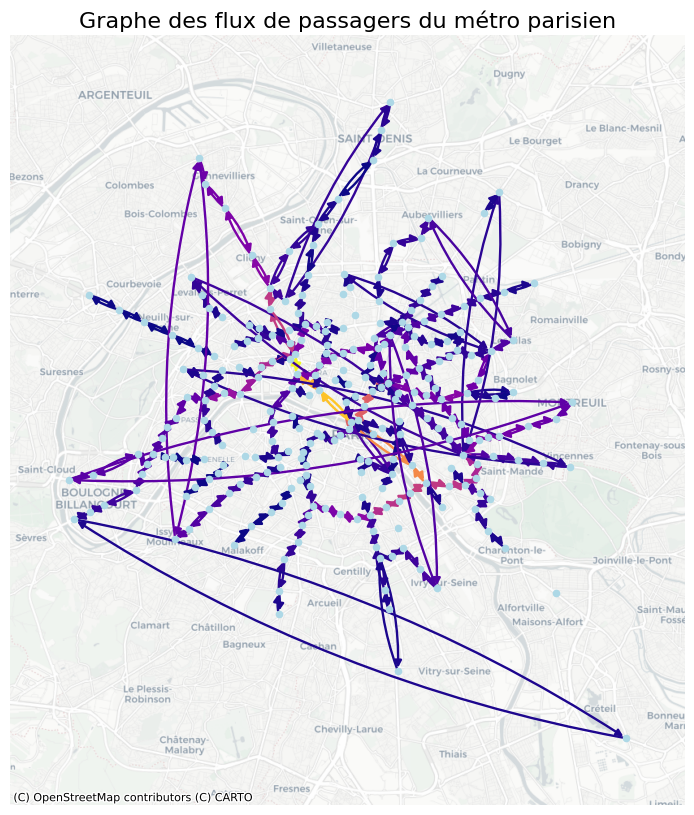

In [ ]:
graph_flux(matrice_flux, position_gps)

In [29]:
def nombre_chemin(station1,station2, G):
    # Trouver tous les chemins entre Station_A et Station_F
    all_paths = list(nx.all_simple_paths(G, source=station1, target=station2))
    # Afficher les chemins avec des nformations détaillées
    return (len(all_paths))

In [30]:
df_ligne_insuppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])
df_ligne_suppressible = pd.DataFrame(columns=['de Ligne','de Station', 'vers Ligne', 'vers Station'])

In [31]:
compteur = 0
for index, row in plan_metro.iterrows():    
    stationDe = row['de Station']
    stationVers = row['vers Station']
    if stationDe != stationVers and stationDe in G_metro and stationVers in G_metro: 
        # Appelez la fonction pour obtenir le nombre de chemins
        nb_chemin = nombre_chemin(stationDe, stationVers, G_metro)
        print(f"Nombre de chemins entre {stationDe} et {stationVers}: {nb_chemin}")
        if nb_chemin > 1:
            compteur += 1
            df_ligne_suppressible.loc[len(df_ligne_suppressible)]=row
        else :
            df_ligne_insuppressible.loc[len(df_ligne_insuppressible)]=row
    else :
        df_ligne_insuppressible.loc[len(df_ligne_insuppressible)]=row
print('Nb_arete suppressible:',compteur)

Nombre de chemins entre Esplanade de La Défense et La Défense: 1
Nombre de chemins entre Pont de Neuilly et Esplanade de La Défense: 1
Nombre de chemins entre Les Sablons et Pont de Neuilly: 1
Nombre de chemins entre Porte Maillot et Les Sablons: 1
Nombre de chemins entre Argentine et Porte Maillot: 1
Nombre de chemins entre Franklin D. Roosevelt et George V: 1
Nombre de chemins entre Tuileries et Concorde: 1
Nombre de chemins entre Hôtel de Ville et Châtelet: 849
Nombre de chemins entre Saint-Paul et Hôtel de Ville: 1181
Nombre de chemins entre Bastille et Saint-Paul: 1181
Nombre de chemins entre Gare de Lyon et Bastille: 975
Nombre de chemins entre Porte de Vincennes et Nation: 1
Nombre de chemins entre Saint-Mandé et Porte de Vincennes: 1
Nombre de chemins entre Bérault et Saint-Mandé: 1
Nombre de chemins entre Château de Vincennes et Bérault: 1
Nombre de chemins entre Porte Dauphine et Château de Vincennes: 1
Nombre de chemins entre Victor Hugo et Porte Dauphine: 1
Nombre de chemin

In [32]:
print(len(df_ligne_insuppressible))
print(len(df_ligne_suppressible))

756
254


In [37]:
def generate_one_problem():
    # Étape 1 : Nombre aléatoire de lignes cassées à simuler
    nb_lignes_cassees = random.randint(1,1)
    ##nb_lignes_cassees = random.randint(1, df_ligne_suppressible)

    lignes_cassees = df_ligne_suppressible.sample(nb_lignes_cassees)

    # Étape 3 : Créer le DataFrame final
    lignes_restantes = pd.concat([df_ligne_suppressible, lignes_cassees]).drop_duplicates(keep=False)

    # Combiner avec les lignes insuppressibles
    df_final = pd.concat([df_ligne_insuppressible, lignes_restantes], ignore_index=True)

    """# Affichage des résultats
    print("Lignes insuppressibles :")
    print(df_ligne_insuppressible)
    print("\nLignes suppressibles (complètes) :")
    print(df_ligne_suppressible)
    print(f"\nLignes cassées (aléatoires, {nb_lignes_cassees} lignes) :")
    print(lignes_cassees)
    print("\nDataFrame final combiné :")
    print(df_final)"""
    return df_final

In [38]:
def generate_train_dataset(n):
    train_dataset = []
    for _ in range (n):
        train_dataset.append(generate_one_problem())
    return train_dataset

In [39]:
dataset_train1 = generate_train_dataset(200)

In [40]:
dataset_train1[70]

,de Ligne,de Station,vers Ligne,vers Station
0,1,Charles de Gaulle - Étoile,2,Charles de Gaulle - Étoile
1,1,Charles de Gaulle - Étoile,6,Charles de Gaulle - Étoile
2,1,Franklin D. Roosevelt,9,Franklin D. Roosevelt
3,1,Champs-Élysées - Clemenceau,13,Champs-Élysées - Clemenceau
4,1,Concorde,8,Concorde
...,...,...,...,...
1004,14,Saint-Lazare,14,Madeleine
1005,14,Madeleine,14,Pyramides
1006,14,Pyramides,14,Châtelet
1007,14,Châtelet,14,Gare de Lyon
